In [1]:
%run ../setup.py

In [3]:
t, y = np.loadtxt('../data/dsct_eigenfrequencies.txt', usecols=(0,1)).T
y *= 1e3

In [4]:
from maelstrom.utils import amplitude_spectrum

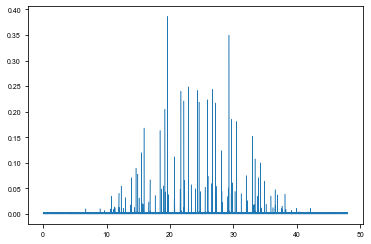

In [5]:
plt.plot(*amplitude_spectrum(t,y, fmax=48), linewidth=0.5)

In [6]:
from exoplanet.utils import eval_in_model
from exoplanet.orbits import get_true_anomaly
import pymc3 as pm
import theano.tensor as tt
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt
import theano
from tqdm import tqdm

class SyntheticBinary(object):
    """
    This class makes a synthetic light curve and injects a time delay signal corresponding to the input binary orbit parameters    
    """
    def __init__(self, time, freq, amplitude, 
                 period, eccen, asini, varpi, phi):
        self.time = time
        self.freq = freq
        self.amplitude = amplitude
        self.period, self.eccen, self.asini, self.varpi, self.phi = period, eccen, asini, varpi, phi
        
        self.make_lightcurve()
        self.flux = self.flux_true
        
    def make_lightcurve(self):
        self.flux_true = np.zeros(len(self.time))
        
        with pm.Model() as model:
            #M = tt.zeros_like(tt.constant(self.time) - self.tref) + 2.0 * np.pi * (tt.constant(self.time)) / self.period
            M = 2.0 * np.pi * tt.constant(self.time) / self.period - self.phi
            f = get_true_anomaly(M, self.eccen + tt.zeros_like(M))
            tau_tens = ((1 - tt.square(self.eccen)) * tt.sin(f+self.varpi) / (1 + self.eccen*tt.cos(f))) * (self.asini / 86400.)
            self.tau = eval_in_model(tau_tens)
            
        for j, A_j in tqdm(zip(self.freq, self.amplitude), total=len(self.freq)):
            omega = 2 * np.pi * j
            # Add time delay and random phase term
            self.flux_true += A_j * np.sin(omega * (self.time - self.tau - np.random.rand()*2*np.pi))# + A_j * np.sin(omega * (self.time - self.tau))
            
    def add_noise(self, snr=5):
        # Add noise
        s_rms = self.amplitude.max() / (np.sqrt(np.pi / len(self.time)) * snr)
        #print(s_rms, self.amplitude)
        #print(np.random.normal(loc=0.0, scale=s_rms, size=len(self.time)))
        self.flux = self.flux_true + np.random.normal(loc=0.0, scale=s_rms, size=len(self.time))
        #self.flux_err = noise * np.std(self.flux_true)
        #self.flux = self.flux_true + self.flux_err * np.random.randn(len(self.flux_true))

In [7]:
from maelstrom.utils import mass_function
import astropy.units as u

In [8]:

from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt
import theano

def gen_model(time, flux, freq, period_guess, a_guess, with_gp=False, with_eccen=False):
    new_model = pm.Model()
    with new_model:
        # Period
#         logP = pm.Normal("logP", mu=np.log(period_guess), sd=50, shape=1, testval=np.log(period_guess))
        logP = pm.Bound(pm.Normal,
                                 lower=np.log(1),
                                 upper=np.log(1500))("logP", mu=np.log(period_guess), sd=5, shape=1, testval=np.log(period_guess))
        period = pm.Deterministic("period", pm.math.exp(logP))
        asini = pm.Normal('asini', mu=a_guess, sd=3, testval=a_guess)
        phi = xo.distributions.Angle('phi', testval=0)
        mean = pm.Normal("mean", mu=np.mean(flux), sd=10.0, testval=np.mean(flux))
        logs_lc = pm.Normal('logs_lc', mu=np.log(np.median(np.abs(np.diff(flux)))), sd=1, testval=np.log(np.median(np.abs(np.diff(flux)))))
        sigma = pm.Deterministic('sigma', tt.exp(2*logs_lc))
        #     logs_lc = pm.HalfNormal("logs_lc",  sigma=0.25, testval=0.05)
        M = 2.0 * np.pi * (time) / period - phi

        if with_eccen:
            varpi = xo.distributions.Angle('varpi', testval=0)
            eccen = pm.Uniform("ecc", lower=0.0, upper=1.0, testval=0.001)
            f = get_true_anomaly(M, eccen + tt.zeros_like(M))
            psi = (1 - tt.square(eccen)) * tt.sin(f+varpi) / (1 + eccen*tt.cos(f))
        else:
            psi = tt.sin(M)

        lognu = pm.Normal("lognu", mu=np.log(freq), sd=0.1, shape=len(freq))
        nu = pm.Deterministic("nu", tt.exp(lognu))
        tau = ((asini) / 86400) * psi[:, None]
        arg = 2. * np.pi * nu * (time[:, None] - tau)
        D = tt.concatenate((tt.cos(arg), tt.sin(arg)), axis=-1)
        w = tt.slinalg.solve(tt.dot(D.T, D), tt.dot(D.T, flux))
        pm.Deterministic('w', w)
        lc_model = tt.dot(D, w)
        full_lc = lc_model - mean

        if with_gp:
            logw0 = pm.Bound(pm.Normal,
                             lower=np.log(2*np.pi/100.0),
                             upper=np.log(2*np.pi/2))("logw0", mu=np.log(2*np.pi/10), sd=10,
                                                        testval=np.log(2*np.pi/10))
            logpower = pm.Normal("logpower", mu=np.log(np.var(flux)), sd=10)
            logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
            kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
            gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)

            pm.Potential("obs", gp.log_likelihood(flux - full_lc))
        else:
            pm.Normal('obs', mu=full_lc, 
                      sd=sigma, 
                      observed=flux)
            
        plt.plot(lc.time, xo.eval_in_model(psi * asini))
        plt.plot(lc.time, lc.tau*86400)
        plt.show()
    return new_model

In [9]:
np.exp(-1.0048*np.log(358.4)+6.6173)

2.028747079785426

In [6]:
(0.2153*u.AU).to(u.m) / (299792458 * u.m / u.s)

<Quantity 107.43572996 s>

In [10]:
from maelstrom.utils import mass_function
import astropy.units as u
stellar_mass = 2.8
((mass_function(51.4167*u.day,107*u.s).to(u.M_jup))**(1/3) * ((stellar_mass*u.M_sun).to(u.M_jup))**(2/3)).to(u.M_sun)

<Quantity 1.57415409 solMass>

In [14]:
mass_function(51.4167*u.day,107*u.s)**(1/3) * ((stellar_mass*u.M_sun))**(2/3)

<Quantity 1.57415409 solMass>

In [11]:
masses = [1,2,5,10]
periods = [1000,1000,1000]
asinis = [0.63, 1.3, 3.15, 6.3]

100%|██████████| 3/3 [00:00<00:00, 578.82it/s]


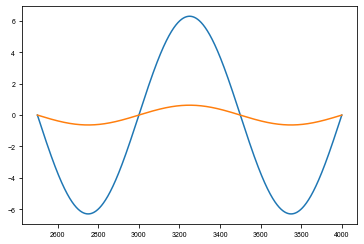

In [26]:
freqs = np.array([30, 40, 50])#dsct_freq
amps = np.array([0.8, 0.8, 1])#dsct_amp
time = t
period_t = 1000

lc = SyntheticBinary(time, freqs, amps,
                     1000, 0, 0.63, 0, 0)
np.random.seed(23)
lc.add_noise(snr=358.4)
asini = 6.3
model = gen_model(lc.time, lc.flux, freqs, period_t, asini)
with model:
    trace = pm.load_trace('traces/planet_test/1000d_' + str(asini))

In [28]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
asini,6.073043,7.390379e-01,2.129896e-02,4.653193,7.481658,1124.397549,0.999625
mean,0.003185,1.600653e-03,3.854638e-05,0.000237,0.006296,1665.888180,0.999909
logs_lc,-0.425954,1.311768e-03,3.325541e-05,-0.428361,-0.423199,1473.459910,1.000670
lognu__0,3.401197,3.392154e-08,8.900933e-10,3.401197,3.401197,1415.997799,0.999502
lognu__1,3.688879,2.558051e-08,6.231906e-10,3.688879,3.688880,1768.888355,0.999922
lognu__2,3.912023,1.580393e-08,4.376953e-10,3.912023,3.912023,1235.094730,0.999522
logP__0,6.891302,3.847691e-02,1.966324e-03,6.820623,6.968703,296.949756,1.003496
period__0,984.414866,3.830813e+01,1.980916e+00,916.555670,1062.842973,286.264180,1.003772
phi,0.381184,7.901470e-01,3.991058e-02,-1.247833,1.849276,305.329808,1.002450
sigma,0.426601,1.119195e-03,2.837694e-05,0.424551,0.428957,1473.350702,1.000666


In [30]:
df = pm.trace_to_dataframe(trace, varnames=['period', 'asini'])
masses = (mass_function(df['period__0'].values*u.day, df['asini'].values*u.s).to(u.M_jup))**(1/3) * ((1.8*u.M_sun).to(u.M_jup))**(2/3)
upper, med, lower = np.nanpercentile(masses, [84.13, 50, 15.86])
print(med, upper-med, med-lower)

9.74708341732789 1.2567683704560668 1.2272219680454945


100%|██████████| 3/3 [00:00<00:00, 233.53it/s]


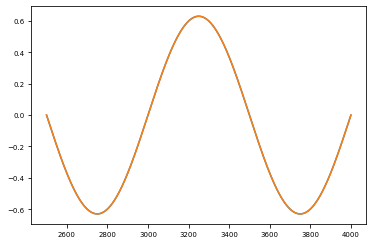

optimizing logp for variables: [logs_lc, mean]
19it [00:00, 35.38it/s, logp=-4.159078e+04]
message: Optimization terminated successfully.
logp: -78197.92944419385 -> -41590.77759907873
optimizing logp for variables: [phi]
91it [00:02, 35.78it/s, logp=-4.156959e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -41590.77759907873 -> -41569.58584362348
optimizing logp for variables: [lognu]
172it [00:04, 38.62it/s, logp=-4.156850e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -41569.58584362348 -> -41568.50070861713
optimizing logp for variables: [lognu, logs_lc, mean, phi, asini, logP]
94it [00:02, 33.19it/s, logp=-2.712410e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: -41568.50070861713 -> -41568.50070861713
optimizing logp for variables: [asini]
5it [00:00, 18.57it/s, logp=-4.156844e+04]
message: Optimization terminated successfully.
logp: -41568.50070861713 -> -41568.4420774338
optim

{'logP_interval__': array([2.69257859]), 'asini': array(0.80417011), 'phi_angle__': array([ 3.09910996, -3.22421119]), 'mean': array(0.00324752), 'logs_lc': array(-0.42598997), 'lognu': array([3.4011974 , 3.68887948, 3.91202301]), 'logP': array([6.84946934]), 'period': array([943.38015911]), 'phi': array(2.37597601), 'sigma': array(0.42656951), 'nu': array([30.00000058, 40.00000121, 50.00000024]), 'w': array([ 0.63623912,  0.42156758, -0.99662832, -0.48704184,  0.6819688 ,
        0.07106055])}
1000 0.63


Sampling 2 chains: 100%|██████████| 2000/2000 [2:16:09<00:00,  4.07draws/s]  
ERROR:pymc3:There were 163 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 118 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████| 3/3 [00:00<00:00, 526.94it/s]


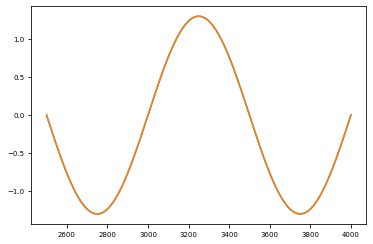

optimizing logp for variables: [logs_lc, mean]
98it [00:02, 46.71it/s, logp=-4.159076e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -74541.04678994261 -> -41590.76373539162
optimizing logp for variables: [phi]
16it [00:00, 37.09it/s, logp=-4.157024e+04]
message: Optimization terminated successfully.
logp: -41590.76373539162 -> -41570.244754170846
optimizing logp for variables: [lognu]
97it [00:02, 41.17it/s, logp=-4.156989e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -41570.244754170846 -> -41569.887885041535
optimizing logp for variables: [lognu, logs_lc, mean, phi, asini, logP]
90it [00:02, 35.06it/s, logp=-2.716850e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: -41569.887885041535 -> -41569.887885041535
optimizing logp for variables: [asini]
5it [00:00, 41.76it/s, logp=-4.156985e+04]
message: Optimization terminated successfully.
logp: -41569.887885041535 -> -41569.85015694809

{'logP_interval__': array([2.5211684]), 'asini': array(1.18188849), 'phi_angle__': array([ 0.22726903, -4.46635785]), 'mean': array(0.00324796), 'logs_lc': array(-0.42598173), 'lognu': array([3.40119737, 3.68887947, 3.91202301]), 'logP': array([6.76920853]), 'period': array([870.62254579]), 'phi': array(3.09075186), 'sigma': array(0.42657655), 'nu': array([29.99999964, 40.00000079, 50.00000002]), 'w': array([ 0.25083399,  0.7801404 , -0.4562506 , -0.75974455,  0.17054801,
       -0.89341709])}
1000 1.3


Sampling 2 chains: 100%|██████████| 2000/2000 [19:28<00:00,  7.08draws/s] 
ERROR:pymc3:There were 313 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████| 3/3 [00:00<00:00, 577.62it/s]


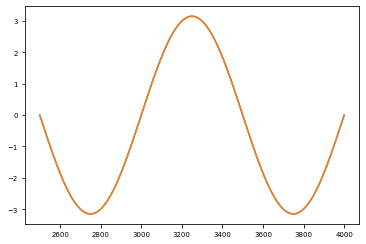

optimizing logp for variables: [logs_lc, mean]
19it [00:00, 38.82it/s, logp=-4.159076e+04]
message: Optimization terminated successfully.
logp: -74526.96894194031 -> -41590.76227887492
optimizing logp for variables: [phi]
10it [00:00, 24.53it/s, logp=-4.157025e+04]
message: Optimization terminated successfully.
logp: -41590.76227887492 -> -41570.247478377285
optimizing logp for variables: [lognu]
79it [00:02, 38.04it/s, logp=-4.156989e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -41570.247478377285 -> -41569.89060382406
optimizing logp for variables: [lognu, logs_lc, mean, phi, asini, logP]
103it [00:02, 35.28it/s, logp=-2.192736e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: -41569.89060382406 -> -41569.89060382406
optimizing logp for variables: [asini]
5it [00:00, 19.24it/s, logp=-4.156985e+04]
message: Optimization terminated successfully.
logp: -41569.89060382406 -> -41569.84899495979
optimizing logp for variab

{'logP_interval__': array([2.70035429]), 'asini': array(3.03502758), 'phi_angle__': array([4.17623067, 1.59971248]), 'mean': array(0.00324796), 'logs_lc': array(-0.42598214), 'lognu': array([3.40119737, 3.68887947, 3.91202301]), 'logP': array([6.85283522]), 'period': array([946.56081395]), 'phi': array(1.20498534), 'sigma': array(0.4265762), 'nu': array([29.99999963, 40.00000078, 50.00000001]), 'w': array([ 0.25069921,  0.78016624, -0.45630216, -0.75978892,  0.17041598,
       -0.8933802 ])}
1000 3.15


Sampling 2 chains: 100%|██████████| 2000/2000 [12:46<00:00,  1.50draws/s]
ERROR:pymc3:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.
100%|██████████| 3/3 [00:00<00:00, 556.74it/s]


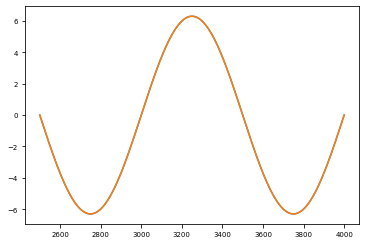

optimizing logp for variables: [logs_lc, mean]
19it [00:00, 38.84it/s, logp=-4.159076e+04]
message: Optimization terminated successfully.
logp: -74529.95234319022 -> -41590.760004069096
optimizing logp for variables: [phi]
158it [00:04, 36.97it/s, logp=-4.157024e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -41590.760004069096 -> -41570.24489645806
optimizing logp for variables: [lognu]
73it [00:01, 41.56it/s, logp=-4.156989e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -41570.24489645806 -> -41569.88918133692
optimizing logp for variables: [lognu, logs_lc, mean, phi, asini, logP]
170it [00:04, 36.42it/s, logp=-4.156989e+04]
message: Desired error not necessarily achieved due to precision loss.
logp: -41569.88918133692 -> -41569.88918126891
optimizing logp for variables: [asini]
5it [00:00, 42.32it/s, logp=-4.156985e+04]
message: Optimization terminated successfully.
logp: -41569.88918126891 -> -41569.84672447267
o

{'logP_interval__': array([2.76832878]), 'asini': array(6.17754434), 'phi_angle__': array([2.4414353 , 3.74691788]), 'mean': array(0.00324795), 'logs_lc': array(-0.42598229), 'lognu': array([3.40119737, 3.68887947, 3.91202301]), 'logP': array([6.88130293]), 'period': array([973.8944456]), 'phi': array(0.57748861), 'sigma': array(0.42657606), 'nu': array([29.99999962, 40.00000077, 50.00000002]), 'w': array([ 0.25062902,  0.78016349, -0.45609033, -0.75981193,  0.17040637,
       -0.89346957])}
1000 6.3


Sampling 2 chains: 100%|██████████| 2000/2000 [08:36<00:00,  2.21draws/s]
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


In [65]:
freqs = np.array([30, 40, 50])#dsct_freq
amps = np.array([0.8, 0.8, 1])#dsct_amp
time = t
period_t = 1000

for asini in asinis:
    lc = SyntheticBinary(time, freqs, amps,
                         period_t, 0, asini, 0, 0)
    np.random.seed(23)
    lc.add_noise(snr=358.4)
    model = gen_model(lc.time, lc.flux, freqs, period_t, asini)
    
    with model:
        map_params = xo.optimize(start=None, vars=[model.mean,model.logs_lc])
        map_params = xo.optimize(start=map_params, vars=[model.phi])
        map_params = xo.optimize(start=map_params, vars=[model.lognu])
        map_params = xo.optimize(start=map_params)

        map_params = xo.optimize(start=map_params, vars=[model.asini])
        map_params = xo.optimize(start=map_params)
        map_params = xo.optimize(start=map_params, vars=[model.logP])
    print(map_params)
    print(period_t, asini)
    sampler = xo.PyMC3Sampler(start=100, window=100, finish=500, chains=2)
    with model:
        burnin = sampler.tune(tune=1000, step_kwargs=dict(target_accept=0.9), start=map_params)
        trace = sampler.sample(draws=1000)
    
    pm.save_trace(trace, 'traces/planet_test/1000d_' + str(asini))

In [66]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
asini,6.073043,7.390379e-01,2.129896e-02,4.653193,7.481658,1124.397549,0.999625
mean,0.003185,1.600653e-03,3.854638e-05,0.000237,0.006296,1665.888180,0.999909
logs_lc,-0.425954,1.311768e-03,3.325541e-05,-0.428361,-0.423199,1473.459910,1.000670
lognu__0,3.401197,3.392154e-08,8.900933e-10,3.401197,3.401197,1415.997799,0.999502
lognu__1,3.688879,2.558051e-08,6.231906e-10,3.688879,3.688880,1768.888355,0.999922
lognu__2,3.912023,1.580393e-08,4.376953e-10,3.912023,3.912023,1235.094730,0.999522
logP__0,6.891302,3.847691e-02,1.966324e-03,6.820623,6.968703,296.949756,1.003496
period__0,984.414866,3.830813e+01,1.980916e+00,916.555670,1062.842973,286.264180,1.003772
phi,0.381184,7.901470e-01,3.991058e-02,-1.247833,1.849276,305.329808,1.002450
sigma,0.426601,1.119195e-03,2.837694e-05,0.424551,0.428957,1473.350702,1.000666


100%|██████████| 3/3 [00:00<00:00, 253.66it/s]


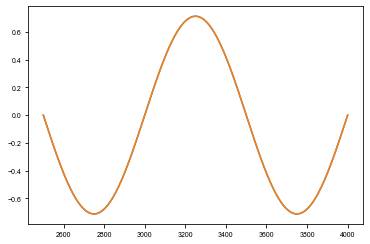

In [34]:
period_t = 1000#periods[3]
asinis = [0.712,3.56,7.12]
freqs = np.array([30, 40, 50])#dsct_freq
amps = np.array([0.8, 0.8, 1])#dsct_amp
time = t

lc = SyntheticBinary(time, freqs, amps,
                         period_t, 0, 0.712, 0, 0)
np.random.seed(23)
lc.add_noise(snr=500)
model = gen_model(lc.time, lc.flux, freqs, period_t, 0.712)
    
with model:
    trace = pm.load_trace('traces/planet_test/1000d_7.12')

In [35]:
df = pm.trace_to_dataframe(trace, varnames=['period', 'asini'])
masses = (mass_function(df['period__0'].values*u.day, df['asini'].values*u.s).to(u.M_jup))**(1/3) * ((1.5*u.M_sun).to(u.M_jup))**(2/3)
upper, med, lower = np.percentile(masses, [84.13, 50, 15.86])
print(med, upper-med, med-lower)

9.876952933618032 0.7746576694752783 0.7273053369797324


In [11]:
from astropy import constants as const
import astropy.units as u

def mass_function(period, asini):
    consts = (4*np.pi**2 * (1*const.c**3)) / (1*const.G)
    si = (asini**3) * consts / (period.to(u.s)**2)
    return si.to(u.M_sun)

In [44]:



stellar_mass = 1.8
(mass_function(1000*u.day, 0.712*u.s).to(u.M_jup))**(1/3) * ((1.5*u.M_sun).to(u.M_jup))**(2/3)

<Quantity 1.00080531 jupiterMass>